In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, RFE
import yfinance as yf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import itertools

In [2]:
stock = 'NKE'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def xgb_strategy(data):
    df1 = data[['Close', 'High', 'Open', 'Low', 'Volume']]
    start_date = '2022-01-01'
    end_date = '2024-01-21'
    df2 = yf.download(stock, start=start_date, end=end_date)

    # Make sure data is sorted by date
    df2.sort_index(inplace=True)
    df2 = df2.droplevel(1, axis=1)
    df = pd.concat((df2, df1))
    
    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Drop NaN values
    df.dropna(inplace = True)

    # Simple & Exponential Moving Averages
    df['SMA_10'] = df['Close'].rolling(window = 10).mean()
    # df['SMA_50'] = df['Close'].rolling(window = 50).mean()
    df['EMA_20'] = df['Close'].ewm(span = 20, adjust = False).mean()

    # Bollinger Bands (20-day)
    rolling_mean = df['Close'].rolling(window = 20).mean()
    rolling_std = df['Close'].rolling(window = 20).std()
    df['boll_upper'] = rolling_mean + (2 * rolling_std)
    df['boll_lower'] = rolling_mean - (2 * rolling_std)

    # MACD & Signal Line
    df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD_signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    # Average True Range (ATR)
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window = 14).mean()

    # ADX (Directional Movement Index)
    df['DM_plus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                             np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DM_minus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                              np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['DI_plus'] = 100 * (df['DM_plus'].rolling(window = 14).mean() / df['ATR'])
    df['DI_minus'] = 100 * (df['DM_minus'].rolling(window = 14).mean() / df['ATR'])
    df['DX'] = (np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])) * 100
    df['ADX'] = df['DX'].rolling(window = 14).mean()

    # Stochastic Oscillator (14-day)
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window = 14).min()) /
                     (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * 100

    # Williams %R (14-day)
    df['williams_R'] = ((df['High'].rolling(window = 14).max() - df['Close']) /
                         (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * -100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)

    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Market Direction (Target)
    
    df['direction'] = np.sign(df['Returns']).astype(int) + 1  # Converts -1, 0, 1 to 0, 1, 2
        
    # Drop NaN values
    df.dropna(inplace = True)

    # Feature Selection Approaches
    features = [col for col in df.columns if col not in ['Returns', 'direction']]
    X = df[features]
    y = df['direction']

    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X, y, discrete_features = False)
    mi_selected_features = pd.Series(mi_scores, index = features).nlargest(10).index.tolist()

    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfe = RFE(rf, n_features_to_select = 10)
    rfe.fit(X, y)
    rfe_selected_features = X.columns[rfe.support_].tolist()

    # Select Top Features (Union of All Methods)
    final_selected_features = list(set(mi_selected_features) | set(rfe_selected_features))

    # Standardize Features
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-03-01'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train XGBoost Model
    model = XGBClassifier(eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Predict & Compute Strategy Returns
    test_data['pos'] = model.predict(X_test) - 1  # Convert to -1, 0, 1
    test_data['xgb_returns'] = test_data['pos'] * test_data['Returns']
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # Plot 'Close' and 'pos' with a secondary y-axis on the first subplot
    test_data[['Close', 'pos']].plot(ax=axes[0], secondary_y='pos')
    axes[0].set_title("Close Price and Position")

    # Plot the cumulative return on the second subplot
    axes[1].plot(np.exp(test_data['xgb_returns'].cumsum()))
    axes[1].set_title("Cumulative Returns")

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['xgb_returns'].sum())
    print(f"Cumulative Return: {cumulative_return:.4f}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
c:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ASUS\anaconda3\Lib\subprocess.py", line 

Cumulative Return: 11.0134


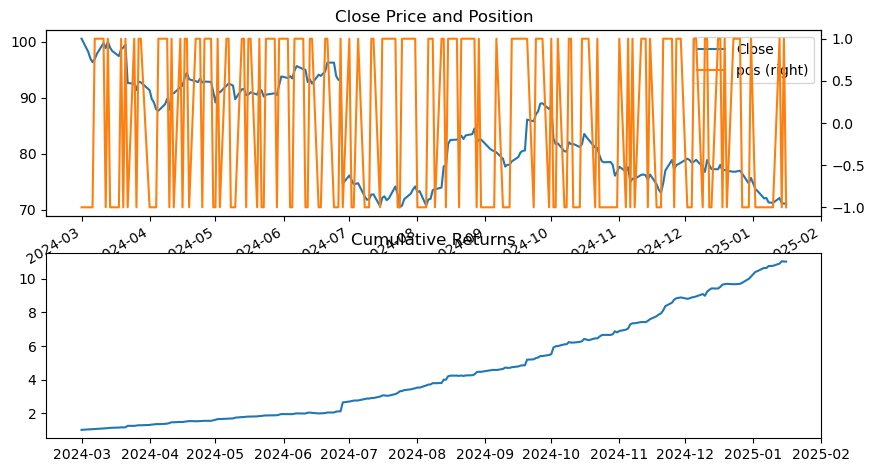

In [3]:
xgb_strategy(src)

In [4]:
stock = 'SOFI'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def LR_strategy(data):
    df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Simple & Exponential Moving Averages
    df['SMA_10'] = df['Close'].rolling(window = 10).mean()
    # df['SMA_50'] = df['Close'].rolling(window = 50).mean()
    df['EMA_20'] = df['Close'].ewm(span = 20, adjust = False).mean()

    # Bollinger Bands (20-day)
    rolling_mean = df['Close'].rolling(window = 20).mean()
    rolling_std = df['Close'].rolling(window = 20).std()
    df['boll_upper'] = rolling_mean + (2 * rolling_std)
    df['boll_lower'] = rolling_mean - (2 * rolling_std)

    # MACD & Signal Line
    df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD_signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    # Average True Range (ATR)
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window = 14).mean()

    # ADX (Directional Movement Index)
    df['DM_plus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                             np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DM_minus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                              np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['DI_plus'] = 100 * (df['DM_plus'].rolling(window = 14).mean() / df['ATR'])
    df['DI_minus'] = 100 * (df['DM_minus'].rolling(window = 14).mean() / df['ATR'])
    df['DX'] = (np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])) * 100
    df['ADX'] = df['DX'].rolling(window = 14).mean()

    # Stochastic Oscillator (14-day)
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window = 14).min()) /
                     (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * 100

    # Williams %R (14-day)
    df['williams_R'] = ((df['High'].rolling(window = 14).max() - df['Close']) /
                         (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * -100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)

    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Market Direction (Target)
    df['direction'] = np.where(df['Returns'] >= 0, 1, 0)

    # Drop NaN values
    df.dropna(inplace = True)

    # Feature Selection Approaches
    features = [col for col in df.columns if col not in ['Returns', 'direction']]
    X = df[features]
    y = df['direction']

    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X, y, discrete_features = False)
    mi_selected_features = pd.Series(mi_scores, index = features).nlargest(10).index.tolist()

    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfe = RFE(rf, n_features_to_select = 10)
    rfe.fit(X, y)
    rfe_selected_features = X.columns[rfe.support_].tolist()

    # Select Top Features (Union of All Methods)
    final_selected_features = list(set(mi_selected_features) | set(rfe_selected_features))

    # Standardize Features
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-03-01'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train XGBoost Model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict & Compute Strategy Returns
    test_data['pos'] = model.predict(X_test)
    test_data['pos'] = np.where(test_data['pos']==0, -1, test_data['pos'])
    test_data['lr_returns'] = test_data['pos'] * test_data['Returns']

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['lr_returns'].sum())
    print(f"Cumulative Return: {cumulative_return:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'SOFI.csv'

In [23]:
LR_strategy(src)

Cumulative Return: 42.0284


In [5]:
stock = 'NKE'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)

def xgboost_monthly(data_train = src, data_test = src):
    df_train = data_train.copy()
    df_test = data_test.copy()
    
    # Combine and preprocess both upfront for consistency
    df_full = pd.concat([df_train, df_test])
    
    # Add features
    df_full['Returns'] = np.log(df_full['Close'] / df_full['Close'].shift(1))
    df_full['SMA_10'] = df_full['Close'].rolling(window=10).mean()
    df_full['EMA_20'] = df_full['Close'].ewm(span=20).mean()
    df_full['boll_upper'] = df_full['Close'].rolling(20).mean() + 2 * df_full['Close'].rolling(20).std()
    df_full['boll_lower'] = df_full['Close'].rolling(20).mean() - 2 * df_full['Close'].rolling(20).std()
    df_full['MACD'] = df_full['Close'].ewm(span=12).mean() - df_full['Close'].ewm(span=26).mean()
    df_full['MACD_signal'] = df_full['MACD'].ewm(span=9).mean()
    df_full['TR'] = df_full[['High', 'Low', 'Close']].apply(
        lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Close']), abs(x['Low'] - x['Close'])), axis=1)
    df_full['ATR'] = df_full['TR'].rolling(window=14).mean()
    df_full['OBV'] = (np.sign(df_full['Close'].diff()) * df_full['Volume']).fillna(0).cumsum()
    df_full['VWAP'] = (df_full['Close'] * df_full['Volume']).cumsum() / df_full['Volume'].cumsum()
    df_full['Aroon_Up'] = df_full['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df_full['Aroon_Down'] = df_full['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)
    df_full['High-Low'] = df_full['High'] - df_full['Low']
    df_full['High-Close'] = np.abs(df_full['High'] - df_full['Close'].shift(1))
    df_full['Low-Close'] = np.abs(df_full['Low'] - df_full['Close'].shift(1))
    df_full['TrueRange'] = df_full[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df_full['high_low'] = df_full['High'] - df_full['Low']
    df_full['high_close'] = np.abs(df_full['High'] - df_full['Close'].shift(1))
    df_full['low_close'] = np.abs(df_full['Low'] - df_full['Close'].shift(1))
    
    for lag in range(1, 6):
        df_full[f'lag_{lag}'] = df_full['Returns'].shift(lag)

    df_full['day_of_week'] = df_full.index.dayofweek
    df_full['month'] = df_full.index.month
    df_full['direction'] = np.where(df_full['Returns'] > 0, 1, 0)

    df_full.dropna(inplace=True)

    all_features = [col for col in df_full.columns if col not in ['Returns', 'direction']]
    scaler = StandardScaler()
    df_full[all_features] = scaler.fit_transform(df_full[all_features])

    # Re-split after processing
    df_train = df_full[df_full.index < '2024-03-01'].copy()
    df_test = df_full[df_full.index >= '2024-03-01'].copy()

    all_test_returns = []

    current_start = pd.to_datetime('2024-03-01')

    while current_start <= df_test.index[-1]:
        current_end = (current_start + pd.DateOffset(months=1)).replace(day=1)
        current_test = df_test[(df_test.index >= current_start) & (df_test.index < current_end)]

        if current_test.empty:
            break

        # Training set
        X_train = df_train[all_features]
        y_train = df_train['direction']

        """
        # Feature selection
        mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False)
        mi_selected = pd.Series(mi_scores, index=X_train.columns).nlargest(10).index.tolist()
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rfe = RFE(rf, n_features_to_select=10)
        rfe.fit(X_train, y_train)
        rfe_selected = X_train.columns[rfe.support_].tolist()
        selected_features = list(set(mi_selected + rfe_selected))
        """
        selected_features = ['TR', 'low_close', 'Aroon_Up', 'high_close', 'High-Close', 'Aroon_Down', 'Low-Close', 'high_low']

        # Train model
        model = XGBClassifier(eval_metric="mlogloss", n_estimators=500)
        model.fit(X_train[selected_features], y_train)

        # Predict
        X_test = current_test[selected_features]
        preds = model.predict(X_test)
        pos = np.where(preds == 0, -1, 1)
        strategy_returns = pos * current_test['Returns']

        all_test_returns.extend(strategy_returns.tolist())

        # Update training set with newly observed data
        df_train = pd.concat([df_train, current_test])
        current_start = current_end

    cumulative_return = np.exp(np.nansum(all_test_returns))
    print(f"Cumulative Return (Monthly updated): {cumulative_return:.4f}")


In [6]:
xgboost_monthly(src.loc[:'2024-03-01'], src.loc['2024-03-01':])

KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

In [7]:
stock = 'NKE'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)

def svm_strategy_monthly(data_train = src, data_test = src):
    df_train = data_train.copy()
    df_test = data_test.copy()
    
    # Combine and preprocess both upfront for consistency
    df_full = pd.concat([df_train, df_test])
    df_train = data_train.copy()
    df_test = data_test.copy()
    
    # Combine and preprocess both upfront for consistency
    df_full = pd.concat([df_train, df_test])
    
    # Add features
    df_full['Returns'] = np.log(df_full['Close'] / df_full['Close'].shift(1))
    df_full['SMA_10'] = df_full['Close'].rolling(window=10).mean()
    df_full['EMA_20'] = df_full['Close'].ewm(span=20).mean()
    df_full['boll_upper'] = df_full['Close'].rolling(20).mean() + 2 * df_full['Close'].rolling(20).std()
    df_full['boll_lower'] = df_full['Close'].rolling(20).mean() - 2 * df_full['Close'].rolling(20).std()
    df_full['MACD'] = df_full['Close'].ewm(span=12).mean() - df_full['Close'].ewm(span=26).mean()
    df_full['MACD_signal'] = df_full['MACD'].ewm(span=9).mean()
    df_full['TR'] = df_full[['High', 'Low', 'Close']].apply(
        lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Close']), abs(x['Low'] - x['Close'])), axis=1)
    df_full['ATR'] = df_full['TR'].rolling(window=14).mean()
    df_full['OBV'] = (np.sign(df_full['Close'].diff()) * df_full['Volume']).fillna(0).cumsum()
    df_full['VWAP'] = (df_full['Close'] * df_full['Volume']).cumsum() / df_full['Volume'].cumsum()

    for lag in range(1, 6):
        df_full[f'lag_{lag}'] = df_full['Returns'].shift(lag)

    df_full['day_of_week'] = df_full.index.dayofweek
    df_full['month'] = df_full.index.month
    df_full['direction'] = np.where(df_full['Returns'] > 0, 1, 0)

    df_full.dropna(inplace=True)

    all_features = [col for col in df_full.columns if col not in ['Returns', 'direction']]
    scaler = StandardScaler()
    df_full[all_features] = scaler.fit_transform(df_full[all_features])

    # Re-split after processing
    df_train = df_full[df_full.index < '2024-03-01'].copy()
    df_test = df_full[df_full.index >= '2024-03-01'].copy()

    all_test_returns = []

    current_start = pd.to_datetime('2024-03-01')

    while current_start <= df_test.index[-1]:
        current_end = (current_start + pd.DateOffset(months=1)).replace(day=1)
        current_test = df_test[(df_test.index >= current_start) & (df_test.index < current_end)]

        if current_test.empty:
            break

        # Training set
        X_train = df_train[all_features]
        y_train = df_train['direction']

        # Feature selection
        mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False)
        mi_selected = pd.Series(mi_scores, index=X_train.columns).nlargest(10).index.tolist()
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rfe = RFE(rf, n_features_to_select=10)
        rfe.fit(X_train, y_train)
        rfe_selected = X_train.columns[rfe.support_].tolist()
        selected_features = list(set(mi_selected + rfe_selected))

        # Train model
        model = SVC(kernel = 'linear') # good for NKE
        # model = LogisticRegression()
        # model = MLPClassifier(hidden_layer_sizes = 5 * [100], random_state = 1)
        model.fit(X_train[selected_features], y_train)

        # Predict
        X_test = current_test[selected_features]
        preds = model.predict(X_test)
        pos = np.where(preds == 0, -1, 1)
        strategy_returns = pos * current_test['Returns']

        all_test_returns.extend(strategy_returns.tolist())

        # Update training set with newly observed data
        df_train = pd.concat([df_train, current_test])
        current_start = current_end

    cumulative_return = np.exp(np.nansum(all_test_returns))
    print(f"Cumulative Return (Monthly updated): {cumulative_return:.4f}")


In [8]:
svm_strategy_monthly(src.loc[:'2024-03-01'], src.loc['2024-03-01':])

KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'